In [ ]:
import os

os.getcwd()

'/home/jupyter/Fine Tuning Scripts'

In [ ]:
os.chdir('/home/jupyter/')

In [ ]:
# !nvidia-smi

In [ ]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("CUDA Device Name:", torch.cuda.get_device_name(0))


PyTorch Version: 2.2.1+cu121
CUDA Available: True
CUDA Version: 12.1
CUDA Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
# !python -m pip install --upgrade pip
# !pip install matplotlib -U

In [ ]:
# !pip install  datasets
# # !pip install -q git+https://github.com/huggingface/transformers.git@add-model-idefics
# !pip install transformers==4.37.2  -U
# !pip install  bitsandbytes sentencepiece==0.1.99 accelerate==0.21.0 loralib
# !pip install  peft
# !pip install hf_transfer  -U
# !pip install pickleshare

In [ ]:
import os

if not os.path.isdir("LLaVA"):
    !git clone https://github.com/haotian-liu/LLaVA.git
else:
    print("LLaVA directory already exists. Skipping clone.")

LLaVA directory already exists. Skipping clone.


In [ ]:
import re

# Define the path to the builder.py file
file_path = 'LLaVA/llava/model/builder.py'

# Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

# Regular expression to find the block between 'vision_tower = model.get_vision_tower()' and 'image_processor = vision_tower.image_processor'
pattern_block = (
    r'(vision_tower = model.get_vision_tower\(\)\n)'
    r'.*?'  # Non-greedy match for any characters (including newlines) between the two markers
    r'(image_processor = vision_tower.image_processor)'
)

replacement_block = (
    r'\1'  # Keep the starting line unchanged
    '        if not vision_tower.is_loaded:\n'
    '            print(\'vision_tower is not loaded so loading it now\')\n'
    '            vision_tower.load_model(device_map=device_map)\n'
    '            vision_tower.to(device=device, dtype=torch.bfloat16)\n'
    '        else:\n'
    '            print(\'vision_tower is loaded\')\n'
    r'        \2'  # Keep the ending line unchanged
)

# Replace the specific block
content = re.sub(pattern_block, replacement_block, content, flags=re.DOTALL)

# Write the modified content back to the file
with open(file_path, 'w') as file:
    file.write(content)

print('The script has been updated successfully.')


The script has been updated successfully.


In [ ]:
# from LLaVA.llava.model.language_model.llava_mistral import LlavaMistralForCausalLM


In [ ]:
import re

# Define the path to the builder.py file
file_path = 'LLaVA/llava/model/builder.py'

# Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

# Regular expression to find 'float16' not preceded by 'b'
pattern = r'(?<!b)float16'

# Check if there are any matches
if re.search(pattern, content):
    # Replace 'float16' with 'bfloat16'
    modified_content = re.sub(pattern, 'bfloat16', content)

    # Write the modified content back to the file
    with open(file_path, 'w') as file:
        file.write(modified_content)

    print('All necessary instances of float16 have been replaced with bfloat16 in', file_path)
else:
    print('No replacement needed. All instances of float16 already have \'b\' before them.')

No replacement needed. All instances of float16 already have 'b' before them.


In [ ]:
os.getcwd()

'/home/jupyter'

In [ ]:
%cd LLaVA

/home/jupyter/LLaVA


In [ ]:
!pip install -e .
# # # !pip install -e . #to see the install logs

In [ ]:
# # !git pull
# # !pip install -e . -q

# !pip install protobuf -q -U
# !pip install --upgrade Pillow -q
# !pip install -e ".[train]" -q
# !pip install flash-attn --no-build-isolation -q

# # IT'S RECOMMENDED TO RESTART THE KERNEL TO ENSURE UPDATED PACKAGES ARE LOADED, THEN RUN THE CELLS BELOW

## Load the model

In [ ]:
# Allows for faster downloading.
%env HF_HUB_ENABLE_HF_TRANSFER=1

env: HF_HUB_ENABLE_HF_TRANSFER=1


In [ ]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
import transformers
from transformers import AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig
import torchvision.transforms as transforms

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

device = "cuda" if torch.cuda.is_available() else "cpu"


# LLaVA 1.6B
model_path = "liuhaotian/llava-v1.6-mistral-7b"


model_name=get_model_name_from_path(model_path)

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=model_name,
    cache_dir='',
    # use_flash_attn=True,
    # load_8bit=True
    # load_4bit=True
)

/opt/conda/envs/test_install/lib/python3.12/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/opt/conda/envs/test_install/lib/python3.12/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the chec

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

vision_tower is loaded


## Examination

In [ ]:
print(model)

LlavaMistralForCausalLM(
  (model): LlavaMistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): Mistr

In [ ]:
print(model.config)
print(tokenizer.pad_token_id)
print(tokenizer)

LlavaMistralConfig {
  "_name_or_path": "liuhaotian/llava-v1.6-mistral-7b",
  "architectures": [
    "LlavaMistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "freeze_mm_mlp_adapter": false,
  "freeze_mm_vision_resampler": false,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "image_aspect_ratio": "anyres",
  "image_crop_resolution": 224,
  "image_grid_pinpoints": [
    [
      336,
      672
    ],
    [
      672,
      336
    ],
    [
      672,
      672
    ],
    [
      1008,
      336
    ],
    [
      336,
      1008
    ]
  ],
  "image_split_resolution": 224,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "mm_hidden_size": 1024,
  "mm_patch_merge_type": "spatial_unpad",
  "mm_projector_lr": null,
  "mm_projector_type": "mlp2x_gelu",
  "mm_resampler_type": null,
  "mm_use_im_patch_token": false,
  "mm_use_im_start_end": false,
  "mm_vision_select_feature": "patch",
  "mm_vision_s

In [ ]:
import torch

# Check dtype of all modules, focusing on those not torch.bfloat16
print("Modules not torch.bfloat16:")
for name, module in model.named_modules():
    if hasattr(module, 'parameters') and list(module.parameters()):
        # Check if any parameter of the module is not bfloat16
        if any(param.dtype != torch.bfloat16 for param in module.parameters()):
            print(f"{name}: {next(module.parameters()).dtype}")
    else:
        # Optionally, acknowledge modules without parameters if needed
        pass

Modules not torch.bfloat16:


In [ ]:
import transformers
import accelerate
import torch

print(f"transformers version: {transformers.__version__}")
print(f"accelerate version: {accelerate.__version__}")
print(f"torch version: {torch.__version__}")


transformers version: 4.37.2
accelerate version: 0.21.0
torch version: 2.2.1+cu121


## Image loading and processing


In [ ]:
import re
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
import requests
from io import BytesIO

from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

# function to create prompts
def create_prompt(query, model, model_name=model_name, caption=None):
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in query:
        if model.config.mm_use_im_start_end:
            query = re.sub(IMAGE_PLACEHOLDER, image_token_se, query)
        else:
            query = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, query)
    else:
        if model.config.mm_use_im_start_end:
            query = image_token_se + "\n" + query
        else:
            query = DEFAULT_IMAGE_TOKEN + "\n" + query

    # print(f"Prompt: in create prompt {query}")

    conv_mode = infer_conv_mode(model_name)
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], query)
    if caption is not None:
        conv.append_message(conv.roles[1], caption)
    else:
        conv.append_message(conv.roles[1], None)
    return conv.get_prompt()

# function to infer conversation mode
def infer_conv_mode(model_name):
    if "llama-2" in model_name.lower():
        return "llava_llama_2"
    elif "mistral" in model_name.lower():
        return "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        return "chatml_direct"
    elif "v1" in model_name.lower():
        return "llava_v1"
    elif "mpt" in model_name.lower():
        return "mpt"
    else:
        return "llava_v0"

def load_image(image_input):
    # Check if the input is a string (path or URL)
    if isinstance(image_input, str):
        if image_input.startswith("http") or image_input.startswith("https"):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            image = Image.open(image_input).convert("RGB")
    elif isinstance(image_input, Image.Image):
        # Input is already an Image object, return as is
        image = image_input
    else:
        raise ValueError("Unsupported image input type")
    return image

def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

# # function to process images
# def process_and_prepare_images(image_files, image_processor, model, device):
#     images = load_images(image_files)
#     image_sizes = [x.size for x in images]  # Calculate image sizes once
#     images_tensor = process_images(
#         images,
#         image_processor,
#         model.config
#     ).to(
#         device,
#         dtype=torch.bfloat16
#     )
#     return images_tensor, image_sizes

In [ ]:
import torch

# def process_images(images, image_processor, model_config):
#     # Process each image and store the processed tensors in a list
#     processed_tensors = []
#     for image in images:
#         processed = image_processor(image)  # This returns a BatchFeature or similar object
#         tensor = processed['pixel_values']  # Extract the tensor, assuming it's under the 'pixel_values' key
#         processed_tensors.append(tensor)

#     # Stack the processed tensors into a single tensor
#     images_tensor = torch.stack(processed_tensors, dim=0)

#     return images_tensor

def process_images(images, image_processor, model_config):
    processed_images = []
    for image in images:
        processed_output = image_processor(image)
        # Check the type of 'pixel_values'; if it's a list, convert it to a tensor
        if isinstance(processed_output['pixel_values'], list):
            tensor = torch.tensor(processed_output['pixel_values'])
        else:
            tensor = processed_output['pixel_values']
        processed_images.append(tensor)

    # Stack the processed images into a single tensor
    images_tensor = torch.stack(processed_images, dim=0)

    return images_tensor


def process_and_prepare_images(image_files, image_processor, model, device):
    images = load_images(image_files)
    image_sizes = [x.size for x in images]  # Calculate image sizes once

    # Process images and ensure the output is a tensor
    images_tensor = process_images(
        images,
        image_processor,
        model.config
    ).to(
        device,
        dtype=torch.bfloat16
    )

    return images_tensor, image_sizes


## eval model function for generating captions via evaluation

#### Display output

In [ ]:
# import torch
# import re

# def eval_model(tokenizer, model, image_processor, context_len, image_file, query, model_name=model_name, sep=",", temperature=1.0, num_beams=1, max_new_tokens=512):
#     # Model
#     disable_torch_init()

#     # Create prompt using the common function
#     prompt = create_prompt(query, model, model_name)

#     print(f"Prompt: {prompt}")

#     # Process images using the common function
#     if isinstance(image_file, list):
#         images_tensor, image_sizes = process_and_prepare_images(image_file, image_processor, model, model.device)
#     elif isinstance(image_file, str):
#         images_tensor, image_sizes = process_and_prepare_images([image_file], image_processor, model, model.device)
#     else:
#         # If image_file is neither a list nor a string, it's likely an Image object or similar; wrap it in a list
#         images = [image_file]
#         images_tensor, image_sizes = process_and_prepare_images(images, image_processor, model, model.device)

#     # Tokenize the prompt using the custom tokenizer_image_token function
#     input_ids = (
#         tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
#         .unsqueeze(0)
#         .to(model.device)
#     )

#     # print(images_tensor.size())

#     with torch.inference_mode():
#         output_ids = model.generate(
#             input_ids,
#             images=images_tensor,
#             image_sizes=image_sizes,
#             do_sample=temperature != 1.0,
#             temperature=temperature,
#             # top_p=top_p,
#             num_beams=num_beams,
#             max_new_tokens=max_new_tokens,
#             use_cache=True,
#         )

#     outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=False)[0].strip()
#     print(outputs)

#### Return predicted caption

In [ ]:
import torch
import re

def eval_model(tokenizer, model, image_processor, context_len, image_file, query, model_name=model_name, sep=",", temperature=1.0, num_beams=1, max_new_tokens=512):
    # Model setup
    disable_torch_init()

    # Create prompt using the common function
    prompt = create_prompt(query, model, model_name)

    # Process images using the common function
    if isinstance(image_file, list):
        images_tensor, image_sizes = process_and_prepare_images(image_file, image_processor, model, model.device)
    elif isinstance(image_file, str):
        images_tensor, image_sizes = process_and_prepare_images([image_file], image_processor, model, model.device)
    else:
        # If image_file is neither a list nor a string, it's likely an Image object or similar; wrap it in a list
        images = [image_file]
        images_tensor, image_sizes = process_and_prepare_images(images, image_processor, model, model.device)

    # Tokenize the prompt using the custom tokenizer_image_token function
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            do_sample=temperature != 1.0,
            temperature=temperature,
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            use_cache=True,
        )

    # Decode the output, removing special tokens for cleaner captions
    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    return outputs


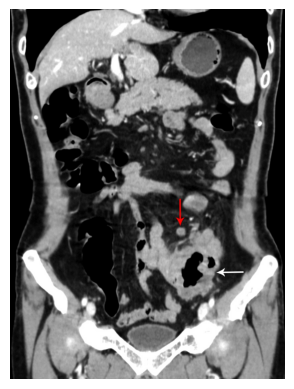

Prompt: [INST] <image>
What do you see in this picture? [/INST]


/var/tmp/ipykernel_7604/4265429433.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  tensor = torch.tensor(processed_output['pixel_values'])
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> The image appears to be a medical scan, likely an MRI (Magnetic Resonance Imaging) or a CT (Computed Tomography) scan, showing a cross-sectional view of a person's abdomen. The scan is focused on the area around the liver, which is the large organ in the upper right part of the image.

There are several areas of interest highlighted in the image:

1. The liver itself, which is the large, darker-colored organ.
2. A red arrow pointing to a specific area within the liver. This could indicate a region of interest for further examination or treatment.
3. Several darker spots scattered throughout the image, which could be indicative of lesions, tumors, or other abnormalities.
4. The spleen, which is the smaller, darker-colored organ located to the left of the liver.
5. The stomach, which is the curved structure to the left of the spleen.
6. The pancreas, which is the lighter-colored structure located below the liver.
7. The kidneys, which are the two bean-shaped structures located at the

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# # Save the current working directory
# cwd = os.getcwd()

# # Change the working directory to where the image is located
# os.chdir('/home/jupyter/imageCLEF 2024 subset/Train')

# Your image URL (make sure to use the raw image URL from GitHub)
image_url = '/home/jupyter/imageCLEF 2024 subset/Train/ImageCLEFmedical_Caption_2024_train_000038.jpg'
image = Image.open(image_url).convert("RGB")

# # Change back to the original directory if needed
# os.chdir(cwd)

# # Download the image and open it with PIL
# response = requests.get(image_url)
# image = Image.open(BytesIO(response.content))

image=load_image(image_url)

import matplotlib.pyplot as plt
# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Now you can pass the processed image to eval_model
eval_model(
    tokenizer,
    model,
    image_processor,
    context_len,
    image,  # Use the processed image
    "What do you see in this picture?"
)

In [ ]:
os.getcwd()

'/home/jupyter/LLaVA'

## Finetuning dataset

Load the dataset that will be used for finetuning

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict, Features, Value, Image

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def tokenize_and_create_labels(example_batch, image_processor, tokenizer, model, device, model_name=model_name, ignore_index=-100, image_token_index=IMAGE_TOKEN_INDEX):
    pad_token_id = tokenizer.pad_token_id
    image_files = example_batch['image']

    images_tensor, image_sizes = process_and_prepare_images(image_files, image_processor, model, device)

    query = "What do you see in this picture?"

    # Tokenize the conversation without the captions to determine which tokens to ignore
    tokenized_conversations_without_caption = [
        tokenizer_image_token(create_prompt(query, model, model_name, None), tokenizer, image_token_index, return_tensors="pt")
        for _ in example_batch['caption']
    ]

    # Tokenize the full conversations with the captions
    tokenized_conversations_with_caption = [
        tokenizer_image_token(create_prompt(query, model, model_name, caption), tokenizer, image_token_index, return_tensors="pt")
        for caption in example_batch['caption']
    ]

    # Pad the tokenized conversations to the same length
    input_ids = pad_sequence([tcwc.squeeze(0) for tcwc in tokenized_conversations_with_caption], batch_first=True, padding_value=pad_token_id).to(device)

    # Create attention_mask (1 for real tokens and 0 for padding tokens)
    attention_mask = (input_ids != pad_token_id).long().to(device)

    # Create the labels tensor which is a copy of input_ids but with ignore_index for non-caption tokens
    labels = torch.full_like(input_ids, fill_value=ignore_index)
    for i, tcwc in enumerate(tokenized_conversations_without_caption):
        # Set ignore_index for the tokens corresponding to the conversation without the caption
        input_id_without_caption = tcwc.squeeze(0)
        labels[i, len(input_id_without_caption):] = input_ids[i, len(input_id_without_caption):]

    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "images": images_tensor,
        "image_sizes": image_sizes,
        "labels": labels,
    }

    return inputs

# Make sure to define the function outside of the lambda to ensure it's serializable
def transform_batch(batch):
    return tokenize_and_create_labels(batch, image_processor, tokenizer, model, device, model_name)

# load and prepare dataset
ds = load_dataset("HoqueMahmudul/clef2024_train_valid_a")

train_ds = ds["train"]
eval_ds = ds["test"]

# print(train_ds)
# print(eval_ds)

# Apply the transformation function to the dataset
train_ds.set_transform(transform_batch)
eval_ds.set_transform(transform_batch)

Parameter 'transform'=<function transform_batch at 0x7f72f4ceff60> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


## LoRA

After specifying the low-rank adapters (LoRA) config, we load the PeftModel using the get_peft_model utility function

Finetuning low rank adaptation of the model

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj",
        "up_proj", "down_proj","gate_proj"
        ],
    lora_dropout=0.05,
    bias="none",
)
model = get_peft_model(model, config)

In [ ]:
model.print_trainable_parameters()

trainable params: 40,108,032 || all params: 7,606,331,392 || trainable%: 0.5272979828644311


## Pre-Training Evaluation

In [ ]:
from PIL import Image

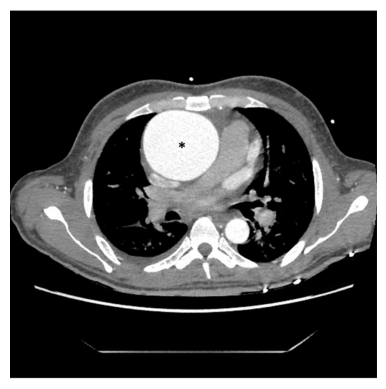

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: [INST] <image>
What do you see in this picture? [/INST]
<s> The image appears to be a medical scan, specifically an X-ray or a similar type of imaging. It shows a side view of a human chest with the heart prominently displayed in the center. The heart is surrounded by the lungs, which are visible on both sides of the chest. The bones of the ribcage are also visible, and there are some markings or annotations on the image, which are likely to be medical notes or measurements. The image is in black and white, which is typical for medical imaging to highlight the details of the internal structures. </s>

Correct caption: CT chest axial view showing a huge ascending aortic aneurysm (*).




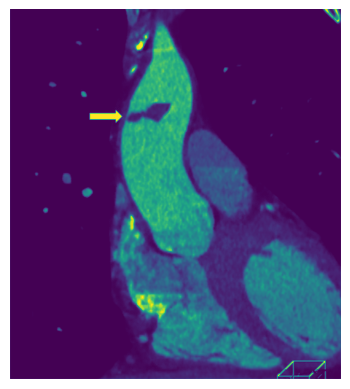

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: [INST] <image>
What do you see in this picture? [/INST]
<s> The image appears to be a medical scan, possibly an MRI (Magnetic Resonance Imaging) or a CT (Computed Tomography) scan. It shows a cross-sectional view of a body part, which could be a joint or a section of the spine. The scan is in grayscale, and there are annotations on it. The arrow points to a specific area, which might be of interest to a medical professional. The annotations and the arrow suggest that this image is being used for diagnostic purposes. </s>

Correct caption: Computed tomography (CT) shows floating thrombosis (white arrow)




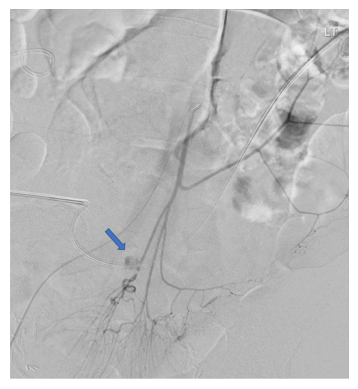

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> The image appears to be a medical scan, possibly an MRI (Magnetic Resonance Imaging) or a CT (Computed Tomography) scan. It shows a cross-sectional view of a body part, which could be a joint or a section of the body with internal structures. There is a blue arrow pointing to a specific area, which might indicate a region of interest or a point of concern that the medical professional is highlighting. The exact nature of the scan and the body part being imaged are not clear from the image alone. </s>

Correct caption: Digitally subtracted angiogram demonstrates active extravasation of the superior rectal artery into the ileal-conduit (blue arrow)




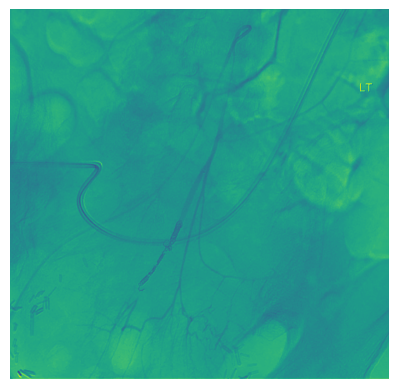

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> The image appears to be a medical scan, possibly an MRI (Magnetic Resonance Imaging) or a CT (Computed Tomography) scan. It shows a cross-sectional view of the body, likely the abdomen or pelvis, with various structures that could be organs, bones, or other tissues. The image is quite detailed, with different shades of gray representing different densities of the tissues. There are also some linear structures that could be vessels or ducts. The "LT" label might refer to a specific area or structure within the image, but without additional context, it's not possible to provide a precise interpretation of the image. </s>

Correct caption: Digitally subtracted angiogram of the IMA demonstrated cessation of flow through the proximal superior rectal artery in the region of the intersection between the artery and ureter with retained perfusion of the rectosigmoid region and resolution of active extravasation




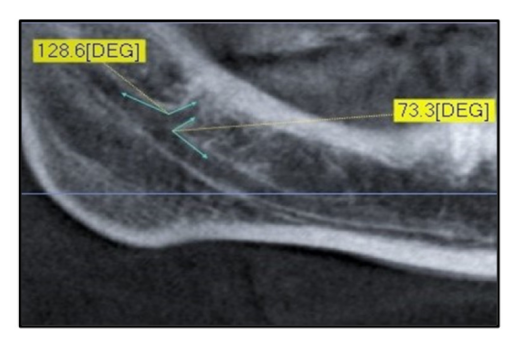

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> The image appears to be a medical scan, possibly an MRI (Magnetic Resonance Imaging) or a CT (Computed Tomography) scan, given the cross-sectional view of a body part. The scan shows a section of the body with various anatomical features labeled. There are two labeled areas: "DEG" and "73." The "DEG" label is likely referring to a specific anatomical structure or region of interest, while "73" could be a reference number or code for the image. The green lines seem to be drawn to highlight certain features or to indicate a measurement or distance within the scan. </s>

Correct caption: Angle measurement of a Type 1 canal.




In [ ]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Limit the number of images to process
num_images_to_process = 5

# Iterate over each example in the evaluation dataset, but only up to num_images_to_process
for i in range(min(num_images_to_process, len(eval_ds))):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Evaluate the model for the given image
    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Print the correct caption
    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


## Training

Hugging Face Trainer

Fine-tuning in mixed precision fp16 can lead to overflows.

## Data Loader


In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_ds is your training dataset prepared as a PyTorch Dataset object
batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Assuming train_loader is your DataLoader instance for the training dataset
for batch in train_loader:
    print(batch.keys())  # Print the dictionary keys to see what data is included in a batch

    # If 'images' is a key, this indicates that images are being loaded
    if 'images' in batch:
        print("Images are included in the DataLoader.")
        print(f"Batch 'images' shape: {batch['images'].shape}")  # Print the shape of the images tensor

    # Similarly, check for other expected keys, like 'input_ids' and 'attention_mask'
    if 'input_ids' in batch and 'attention_mask' in batch:
        # Print the first row of input_ids to check for out-of-range token IDs
        input_ids_first_row = batch['input_ids'][1]
        print(f"First row of 'input_ids': \n{input_ids_first_row.tolist()}")

        # # Check if any token IDs are out of range
        # vocab_size = tokenizer.vocab_size
        # out_of_range_tokens = [token_id for token_id in input_ids_first_row if token_id >= vocab_size]
        # if out_of_range_tokens:
        #     print(f"Out-of-range token IDs: {out_of_range_tokens}")

        # # Decode the first row of input_ids to text, if all token IDs are in range
        # if not out_of_range_tokens:
        #     decoded_inputs = tokenizer.decode(input_ids_first_row, skip_special_tokens=False)
        #     print(f"Decoded input tokens: {decoded_inputs}")
        # else:
        #     print("Cannot decode input_ids due to out-of-range token IDs.")

        print("Text inputs are included in the DataLoader.")
        print(f"Batch 'input_ids' shape: {batch['input_ids'].shape}")
        print(f"Batch 'attention_mask' shape: {batch['attention_mask'].shape}")

        # # Decode the first row of input_ids to text
        # decoded_inputs = tokenizer.decode(batch['input_ids'][0], skip_special_tokens=False)
        # print(f"Decoded input tokens: {decoded_inputs}")

        # Print the first row of labels, replacing ignore_index with the string '[IGNORE]'
        labels = batch['labels'][1].tolist()
        labels_str = ['[IGNORE]' if label == -100 else str(label) for label in labels]
        print(f"Labels: {labels_str}")

        # Print the first row of the attention_mask
        attention_mask_str = batch['attention_mask'][1].tolist()
        print(f"Attention mask: {attention_mask_str}")

    # Optionally, display an image from the batch to visually confirm loading
    if 'images' in batch:
        image_tensor = batch['images'][1]
        print(f"First Row Image Data type: {image_tensor.dtype}")
        print(f"First Row Image Shape: {image_tensor.shape}")
        print(f"First Row Image Value range: [{image_tensor.min()}, {image_tensor.max()}]")

    break  # Only check the first batch

dict_keys(['input_ids', 'attention_mask', 'images', 'image_sizes', 'labels'])
Images are included in the DataLoader.
Batch 'images' shape: torch.Size([8, 1, 3, 336, 336])
First row of 'input_ids': 
[1, 733, 16289, 28793, 28705, -200, 28705, 13, 3195, 511, 368, 1032, 297, 456, 5754, 28804, 733, 28748, 16289, 28793, 22023, 306, 271, 897, 6056, 505, 2204, 8102, 272, 25553, 11969, 1514, 296, 297, 272, 1103, 7280, 305, 8898, 302, 272, 14966, 28723, 28705, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Text inputs are included in the DataLoader.
Batch 'input_ids' shape: torch.Size([8, 148])
Batch 'attention_mask' shape: torch.Size([8, 148])
Labels: ['[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]', '[IGNORE]',

In [ ]:
print(IMAGE_TOKEN_INDEX)

-200


## Training Arguments for the Hugging Face Trainer

In [ ]:
# # clear chache to empty memory

# torch.cuda.empty_cache()

In [ ]:
from transformers import TrainerCallback, EarlyStoppingCallback

In [ ]:
# Define a custom callback
class PrintBestCheckpointCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
        # Print the path of the best checkpoint at the end of training
        print(f"Best model checkpoint: {state.best_model_checkpoint}")

In [ ]:
# from torch.nn import CrossEntropyLoss

# def compute_loss(model, inputs, return_outputs=False):
#     labels = inputs.pop("labels")
#     outputs = model(**inputs)
#     logits = outputs.logits
#     loss_fct = CrossEntropyLoss(ignore_index=ignore_index)
#     loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
#     return (loss, outputs) if return_outputs else loss

specific_directory = "/home/jupyter/Models"
output_model_name = f"{specific_directory}/{model_name}-clef-Train-Valid"


training_args = TrainingArguments(
    # max_steps=30, #COMMENT THIS OUT AFTER TESTING FOR ONE STEP
    output_dir=output_model_name,
    learning_rate=1e-4,
    # fp16=True, #for non ampere gpus
    bf16=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    dataloader_pin_memory=False,
    save_total_limit=5,  # Limit the number of checkpoints to save
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=1095, # 21900 steps with batch size 4,
    eval_steps=1095, # 21900 steps with batch size 4, so 20 evaluations
    logging_steps=1,
    num_train_epochs=10,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # validation loss this is the metric I am monitoring
    greater_is_better=False,  # indicate that lower values of the monitored metric (eval loss) are better
    report_to=None,
    optim="adamw_torch",
)

# Initialize your custom callback
print_best_checkpoint_callback = PrintBestCheckpointCallback()

# Initialize early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Number of evaluation steps with no improvement after which training will be stopped
    early_stopping_threshold=0.01  # Minimum change needed to qualify as an improvement
)

# Initialize the list of callbacks you want to use
# Combine custom callback with the early stopping callback
callbacks = [print_best_checkpoint_callback, early_stopping_callback]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    callbacks=callbacks,  # Add custom callback here
    # compute_loss=compute_loss,  # Pass the custom compute_loss function
)

trainer.train()

Step,Training Loss,Validation Loss
1095,1.800000,1.745019
2190,1.765000,1.705817
3285,1.592000,1.700528
4380,1.540300,1.683712
5475,1.502300,1.719607


In [ ]:
print ("Finished so far")

### Checking trainer state

In [ ]:
!pip install plotly

In [ ]:
## With plotly

# import json
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Load the training history
# with open('/home/jupyter/Models/llava-v1.6-mistral-7b-clef-Train-Valid/checkpoint-9855/trainer_state.json', 'r') as file:
#     trainer_state = json.load(file)

# # Extract loss values from the trainer_state
# training_steps = []
# training_losses = []
# validation_steps = []
# validation_losses = []

# for log_entry in trainer_state['log_history']:
#     if 'loss' in log_entry and 'step' in log_entry:  # This is a training loss entry
#         training_steps.append(log_entry['step'])
#         training_losses.append(log_entry['loss'])
#     elif 'eval_loss' in log_entry and 'step' in log_entry:  # This is a validation loss entry
#         validation_steps.append(log_entry['step'])
#         validation_losses.append(log_entry['eval_loss'])

# # Create subplots
# fig = make_subplots(rows=2, cols=1, subplot_titles=('Training Loss', 'Validation Loss'))

# # Plot the training loss
# fig.add_trace(
#     go.Scatter(x=training_steps, y=training_losses, name='Training Loss', mode='lines', line=dict(color='blue')),
#     row=1, col=1
# )

# # Plot the validation loss
# fig.add_trace(
#     go.Scatter(x=validation_steps, y=validation_losses, name='Validation Loss', mode='lines', line=dict(color='orange')),
#     row=2, col=1
# )

# # Define the tick values as multiples of 1095, considering the range of your steps
# tick_step = 1095
# training_ticks = [x for x in range(0, max(training_steps) + tick_step, tick_step)]
# validation_ticks = [x for x in range(0, max(validation_steps) + tick_step, tick_step)]

# # Update xaxis properties for training loss
# fig.update_xaxes(title_text="Steps", row=1, col=1, tickvals=training_ticks)

# # Update xaxis properties for validation loss
# fig.update_xaxes(title_text="Steps", row=2, col=1, tickvals=validation_ticks)

# # Update yaxis properties
# fig.update_yaxes(title_text="Loss", row=1, col=1)
# fig.update_yaxes(title_text="Loss", row=2, col=1)

# # Update layout and size
# fig.update_layout(height=800, width=800, title_text="Training and Validation Loss Over Steps")
# fig.show()


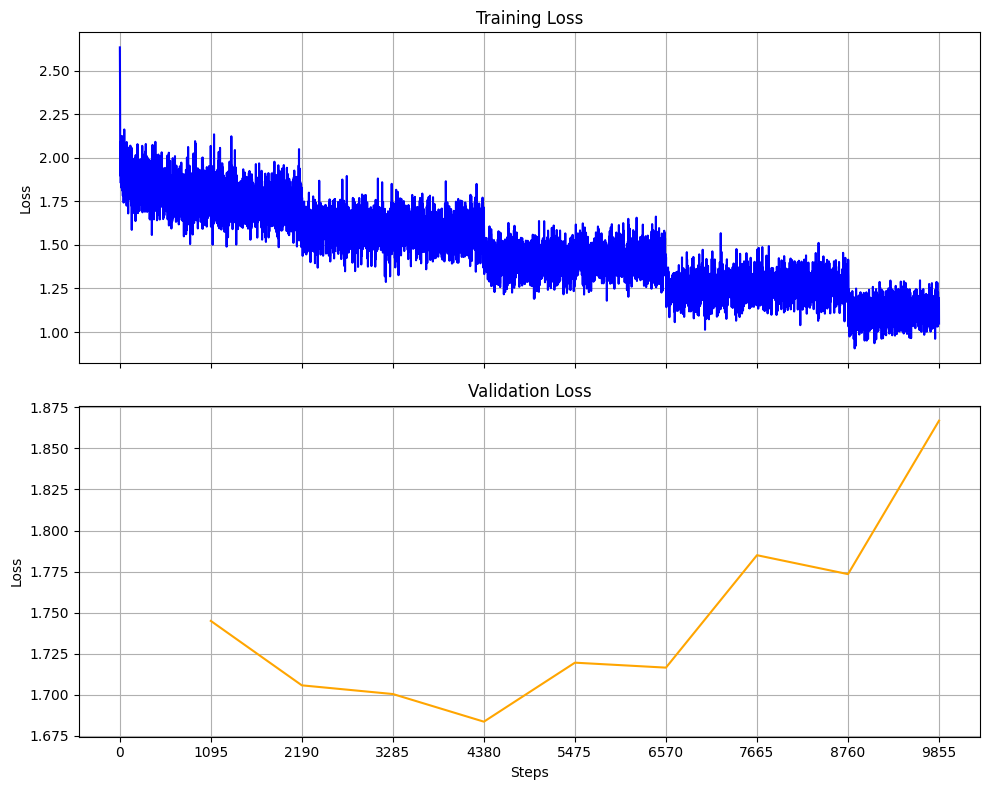

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the training history
with open('/home/jupyter/Models/llava-v1.6-mistral-7b-clef-Train-Valid/checkpoint-9855/trainer_state.json', 'r') as file:
    trainer_state = json.load(file)

# Extract loss values from the trainer_state
training_steps = []
training_losses = []
validation_steps = []
validation_losses = []

for log_entry in trainer_state['log_history']:
    if 'loss' in log_entry and 'step' in log_entry:  # This is a training loss entry
        training_steps.append(log_entry['step'])
        training_losses.append(log_entry['loss'])
    elif 'eval_loss' in log_entry and 'step' in log_entry:  # This is a validation loss entry
        validation_steps.append(log_entry['step'])
        validation_losses.append(log_entry['eval_loss'])

# Set up the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
ax[0].plot(training_steps, training_losses, label='Training Loss', color='blue')
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

# Plot validation loss
ax[1].plot(validation_steps, validation_losses, label='Validation Loss', color='orange')
ax[1].set_title('Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Steps')
ax[1].grid(True)

# Define the tick values as multiples of 1095, considering the range of your steps
tick_step = 1095
xticks = range(0, max(max(training_steps, default=0), max(validation_steps, default=0)) + tick_step, tick_step)
ax[1].set_xticks(xticks)  # Set x-ticks on both subplots

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## eval after training

In [ ]:
# OPTIONALLY LOAD A DIFFERENT CHECKPOINT

from peft import PeftModel

adapter_path="/home/jupyter/Models/llava-v1.6-mistral-7b-clef-Train-Valid/checkpoint-4380"


#  Re-load the base model
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=model_name,
    cache_dir='',
    # use_flash_attn=True,
    # load_8bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
    # load_4bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
)

# Now load the new model on top.
model = PeftModel.from_pretrained(
    model,
    adapter_path,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

vision_tower is loaded


In [ ]:
# Check the Model’s State Dict

# # Print model's state_dict
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Optionally, print the first few weights for a specific layer
# print("First few weights of a specific layer:", model.some_layer.weight.data[0])


In [ ]:
print(model)

PeftModel(
  (base_model): LoraModel(
    (model): LlavaMistralForCausalLM(
      (model): LlavaMistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_fe

In [ ]:
# Print the first 3 items in the dataset
for i in range(min(3, len(eval_ds))):
    print(f"Item {i}:")
    for key in eval_ds[i].keys():
        value = eval_ds[i][key]
        # Since some values can be very large (like tensors), we print their type and size instead of the values themselves
        if hasattr(value, 'shape'):  # Check if the value is a tensor or similar
            print(f"  {key}: {type(value)} with shape {value.shape}")
        else:
            print(f"  {key}: {value}")
    print("\n")


Item 0:
  input_ids: <class 'torch.Tensor'> with shape torch.Size([41])
  attention_mask: <class 'torch.Tensor'> with shape torch.Size([41])
  images: <class 'torch.Tensor'> with shape torch.Size([1, 3, 336, 336])
  image_sizes: (653, 658)
  labels: <class 'torch.Tensor'> with shape torch.Size([41])


Item 1:
  input_ids: <class 'torch.Tensor'> with shape torch.Size([39])
  attention_mask: <class 'torch.Tensor'> with shape torch.Size([39])
  images: <class 'torch.Tensor'> with shape torch.Size([1, 3, 336, 336])
  image_sizes: (598, 669)
  labels: <class 'torch.Tensor'> with shape torch.Size([39])


Item 2:
  input_ids: <class 'torch.Tensor'> with shape torch.Size([58])
  attention_mask: <class 'torch.Tensor'> with shape torch.Size([58])
  images: <class 'torch.Tensor'> with shape torch.Size([1, 3, 336, 336])
  image_sizes: (896, 977)
  labels: <class 'torch.Tensor'> with shape torch.Size([58])




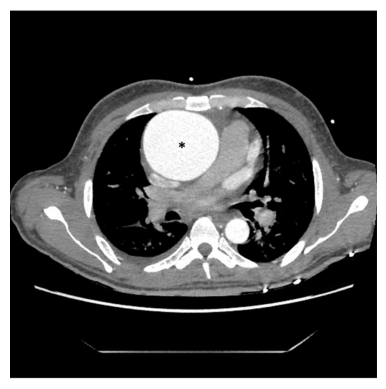

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: [INST] <image>
What do you see in this picture? [/INST]
<s> Computed tomography of the chest showing a large pericardial effusion (asterisk). </s>

Correct caption: CT chest axial view showing a huge ascending aortic aneurysm (*).




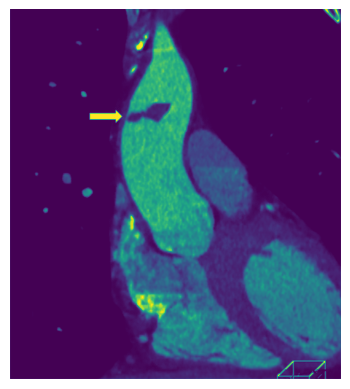

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: [INST] <image>
What do you see in this picture? [/INST]
<s> Sagittal view of the aortic valve. The arrow indicates the vegetation on the aortic valve. </s>

Correct caption: Computed tomography (CT) shows floating thrombosis (white arrow)




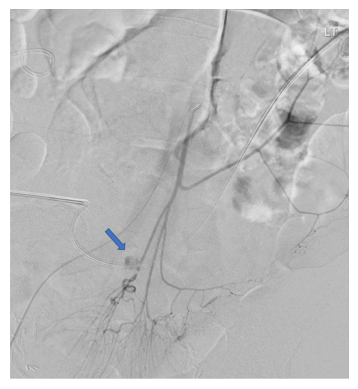

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Angiogram showing the pseudoaneurysm (blue arrow) </s>

Correct caption: Digitally subtracted angiogram demonstrates active extravasation of the superior rectal artery into the ileal-conduit (blue arrow)




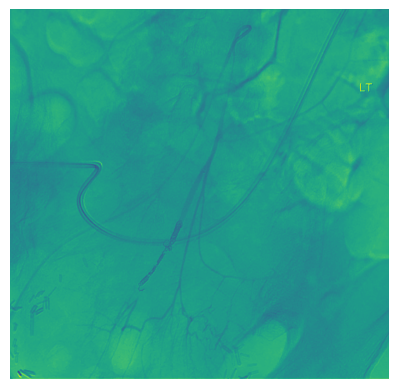

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Angiogram showing the occluded right renal artery. </s>

Correct caption: Digitally subtracted angiogram of the IMA demonstrated cessation of flow through the proximal superior rectal artery in the region of the intersection between the artery and ureter with retained perfusion of the rectosigmoid region and resolution of active extravasation




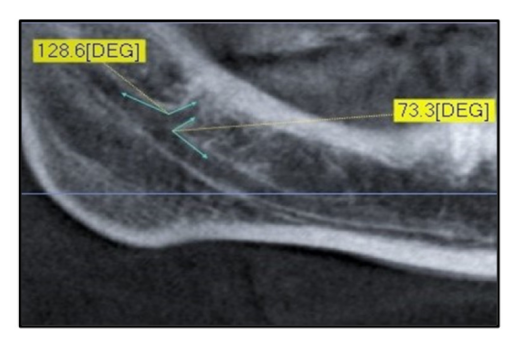

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Measurement of the distance between the skin and the cartilage (D) and the distance between the skin and the bone (DEG). </s>

Correct caption: Angle measurement of a Type 1 canal.




In [ ]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Limit the number of images to process
num_images_to_process = 5

# Iterate over each example in the evaluation dataset, but only up to num_images_to_process
for i in range(min(num_images_to_process, len(eval_ds))):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Evaluate the model for the given image
    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Print the correct caption
    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


## Generating CSV over test set

In [ ]:
# Example usage with a dataset
ds_test = load_dataset("HoqueMahmudul/test_dataset")

test_ds = ds_test['test']

In [ ]:
# Accessing items one by one using test_ds[i] can be inefficient, especially for larger datasets.
# If performance is an issue, consider batch processing if your model and infrastructure support it.


# Now iterate through the test dataset to generate captions
captions = []

# Temporarily disable the transformation to access the original data
test_ds.reset_format()

for i in range(len(test_ds)):
    # Access the original image and image name for the current row
    image = test_ds[i]['image']
    image_name = test_ds[i]['image_name']

    # Evaluate the model for the given image to generate a predicted caption using eval_model function
    predicted_caption = eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Append the correct and predicted captions as a tuple to the captions list
    captions.append((image_name, predicted_caption))

# Create a DataFrame from the captions list with the specified column titles
df_captions_generation_test = pd.DataFrame(captions, columns=['ID', 'predicted_caption'])

# Display the DataFrame to verify the contents
print(df_captions_generation_test)

# Optionally, save the DataFrame to a CSV file
df_captions_generation_test.to_csv('/home/jupyter/Test dataset caption/llava-1.6-4380.csv', index=False)

# Re-enable the transformation if needed
test_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))

In [ ]:
!nvidia-smi

Mon Apr 15 10:11:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              50W / 400W |  31355MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
